<a href="https://colab.research.google.com/github/Programmer484/SL-TicTacToe-NN/blob/main/TicTacToe_Network_Tutorial_(part_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hey! If you're looking for a fun interactive way to get into machine learning, you're in the right place!** 😀

Today, we'll be applying machine learning to train an AI that can play tic-tac-toe on various board sizes! For example, 3 in a row on a 3x3 board, 4 in a row on 6x6 board, etc.

### Demo

First off, let's start off with a sneak peek at what we'll be building throughout this tutorial 👀 Don't worry about understanding all the code for now =)

Instructions:

1. Run the cell called "final code". It contains all the functions that will be used in training and playing.
2. Train the neural network
3. Play against it!


#### Final code

In [ ]:
import math
import pickle
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm


# region Board
"""Board"""
class Board():
    def __init__(self, width, height, win_length, turn, state=None, empties=None):
        self.width = width
        self.height = height
        self.win_length = win_length
        self.turn = turn
        if state == None:
            self.state = tuple([0 for _ in range (width)] for _ in range(height))
            self.empties = [(x, y) for y in range (height) for x in range(width)]
        else:  # Ensures a deepcopy is created
            self.state = tuple(map(list, state))
            self.empties = [*empties]

    def __str__(self):
        symbols = {1: "X", -1: "O", 0: "_"}
        return "\n".join(str([symbols[token] for token in row]) for row in self.state)

    def deepcopy(self):
        return Board(self.width, self.height, self.win_length, self.turn, self.state, self.empties)

    def out_of_bounds(self, square):
        x, y = square
        return (x < 0 or             # Left edge
                y < 0 or             # Top edge
                x >= self.width or   # Right edge
                y >= self.height)    # Bottom edge

    def outcome(self, last_move):
        """
        Determines if the last move resulted in a win or draw.

        The function checks for a winning line by examining four directions from the last move:
        - Diagonal (\)
        - Horizontal (-)
        - Other Diagonal (/)
        - Vertical (|)

        For each direction, it:
        1. Counts consecutive matching symbols in one direction
        2. Counts consecutive matching symbols in the opposite direction
        3. Adds the counts together (including the last move position)
        4. If total count reaches win_length, that player wins
        """
        player = self.state[last_move[1]][last_move[0]]
        directions = [(-1, -1), (-1, 0), (-1, 1),( 0, -1)]
        for dx, dy in directions:
            line_length = 1
            # Check in one direction
            x, y = last_move[0] + dx, last_move[1] + dy
            while not self.out_of_bounds((x, y)) and self.state[y][x] == player:
                line_length += 1
                x += dx
                y += dy
                if line_length >= self.win_length:
                    return player
            # Check in the opposite direction
            x, y = last_move[0] - dx, last_move[1] - dy
            while not self.out_of_bounds((x, y)) and self.state[y][x] == player:
                line_length += 1
                x -= dx
                y -= dy
                if line_length >= self.win_length:
                    return player
        if len(self.empties) == 0:
            return 0
        return None

    def make_move(self, move_coords: tuple):
        try:
            self.empties.remove(move_coords)
            self.state[move_coords[1]][move_coords[0]] = self.turn
            self.turn *= -1
        except:
            raise ValueError("Illegal move")
# endregion

# region MCTS
"""MCTS"""
class MCTS:
    class Node:
        def __init__(self, parent, board, move):
            self.parent = parent
            self.children = []
            self.visit_count = 0
            self.total_value = 0
            self.board = board
            self.move = move

        def is_terminal(self):
            return self.board.outcome(self.move) != None

        def is_leaf(self):
            return self.children == []

    def __init__(self, board):
        self.root_node = self.Node(None, board, (-2,-2))
        self.c = 1.4142

    def uct(self, parent, node, player_num):
        if node.visit_count == 0:
            return float("inf")
        else:
            return (player_num * node.total_value/node.visit_count) + self.c * math.sqrt(math.log(parent.visit_count) / node.visit_count)

    def select(self, node):
        if node.is_leaf():
            return node
        else:
            chosen_node = max(node.children, key=lambda child: self.uct(node, child, node.board.turn))
            return self.select(chosen_node)

    def expand(self, node):
        legal_moves = node.board.empties
        for m in legal_moves:
            child_board = node.board.deepcopy()
            child_board.make_move(m)
            child_node = self.Node(node, child_board, m)
            node.children.append(child_node)

    def evaluate(self, node, playouts):
        outcome = node.board.outcome(node.move)
        if outcome != None:
            return outcome
        else:
            total_value = 0
            for _ in range (playouts):
                total_value += self.play_random_game(node.board.deepcopy())
            return total_value / playouts

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def backpropagate(self, node, evaluation):
        node.visit_count += 1
        node.total_value += evaluation
        if node.parent != None:
            self.backpropagate(node.parent, evaluation)

    def search(self, iterations, playouts=20):
        for _ in range(iterations):
            node = self.select(self.root_node)
            if node.visit_count == 0 or node.is_terminal():
                node_eval = self.evaluate(node, playouts)
                self.backpropagate(node, node_eval)
            else:
                self.expand(node)
                child_node = random.choice(node.children)
                child_node_eval = self.evaluate(child_node, playouts)
                self.backpropagate(child_node, child_node_eval)
        move_probs = [[0 for _ in range(self.root_node.board.width)] for _ in range(self.root_node.board.height)]
        for child_node in self.root_node.children:
            prob = child_node.visit_count / self.root_node.visit_count
            move_probs[child_node.move[1]][child_node.move[0]] = prob
        return move_probs


def choose_move(move_probs, temperature=1):
    """
    Selects a move based on the Monte Carlo Tree Search (MCTS) probabilities, adjusting for temperature to control exploration versus exploitation.
    Parameters:
        temperature (float): Controls the randomness of the move selection.
            Higher temperatures (>1) make the move selection more random (exploration),
            while lower temperatures (<1) make it more greedy (exploitation).
            Default is 1.
    Returns:
        tuple: The selected move as a tuple of (x, y) coordinates.
    """
    # Get all moves and their probabilities from the MCTS output
    moves = []
    probs = []
    for y in range(len(move_probs)):
        for x in range(len(move_probs[y])):
            if move_probs[y][x] > 0:
                moves.append((x, y))
                # Apply temperature to sharpen/flatten distribution
                prob = math.pow(move_probs[y][x], 1 / temperature)
                probs.append(prob)
    # Normalize probabilities
    prob_sum = sum(probs)
    probs = [p / prob_sum for p in probs]
    # Choose move based on probability distribution
    return random.choices(moves, weights=probs)[0]
# endregion

# region Game generation
"""Game generation"""
def generate_games(num_games, mcts_iterations, board_params=(3, 3, 3)):
    training_examples = []
    for game_num in tqdm.tqdm(range(num_games)):
        game_board = Board(*board_params, 1)
        while True:
            mcts_engine = MCTS(game_board)
            move_probs = mcts_engine.search(mcts_iterations)
            training_examples.append(([row[:] for row in game_board.state], move_probs))

            selected_move = choose_move(move_probs)
            game_board.make_move(selected_move)
            if game_board.outcome(selected_move) != None:
                break
    return training_examples


def process_game_data(game_data):
    processed_data = [(torch.tensor(board, dtype=torch.float).flatten(),
                       torch.tensor(move_probs, dtype=torch.float).flatten())
                      for board, move_probs in game_data]
    processed_data = [(board * (-1 if (board != 0).sum().item() % 2 == 1 else 1), probs)
                      for board, probs in processed_data]  # Odd number of pieces means -1 player's turn
    return processed_data
# endregion

# region Network
"""Network"""
class TicTacToeNet(nn.Module):
    def __init__(self, input_size=9, hidden_size=36, output_size=9):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)

        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
# endregion

# region Evaluation
def calculate_accuracy(
    data_set,
    net,
    board_size=(3, 3),
    probability_threshold=0.1
):
    """
    A prediction is considered correct if the network's highest probability move
    is within the probability_threshold of the target's highest probability move.
    """
    correct = 0
    for board, move_probs in data_set:
        output = net(board)
        best_move = torch.argmax(move_probs)
        best_moves = (move_probs >= move_probs[best_move] - probability_threshold).nonzero().flatten()
        if torch.argmax(output) in best_moves:
            correct += 1
    return correct / len(data_set)



class HumanPlayer():
    def move(self, board, **kwargs):
        while True:
            try:
                move = tuple(map(int, input("Enter move as x,y: ").split(',')))
                return move
            except:
                print("Invalid move, try again")


class NetPlayer():
    def __init__(self, net, deterministic=False):
        self.net = net
        self.deterministic = deterministic

    def move(self, board, print_probs=False):
        board_tensor = torch.tensor(board.state, dtype=torch.float).flatten()
        board_tensor = board_tensor * board.turn
        move_probs = self.net(board_tensor)

        if print_probs:
            print("\nNetwork probabilities:")
            for y in range(board.height):
                print([f"{move_probs[y*board.width + x]:.3f}" for x in range(board.width)])

        for move in range(board.width * board.height):
            if (move % board.width, move // board.height) not in board.empties:
                move_probs[move] = 0.0

        if self.deterministic:
            best_move_idx = torch.argmax(move_probs).item()
        else:
            best_move_idx = torch.multinomial(move_probs, 1).item()
        best_move = (best_move_idx % board.width, best_move_idx // board.height)

        return best_move


class RandomPlayer():
    def move(self, board, **kwargs):
        return random.choice(board.empties)


class MCTSPlayer():
    def __init__(self, iterations, deterministic=False):
        self.deterministic = deterministic
        self.iterations = iterations

    def move(self, board, print_probs=False):
        mcts = MCTS(board)
        move_probs = mcts.search(self.iterations)
        move_probs = torch.tensor(move_probs).flatten()

        if print_probs:
            print("\nMCTS probabilities:")
            for row in move_probs:
                print([f"{prob:.3f}" for prob in row])

        if self.deterministic:
            best_move_idx = torch.argmax(move_probs).item()
        else:
            best_move_idx = torch.multinomial(move_probs, 1).item()
        best_move = (best_move_idx % board.width, best_move_idx // board.height)

        return best_move


def play_game(board, player_a, player_b, print_game=False):
    outcome = None
    illegal_move_count = 0
    while outcome == None:
        if print_game:
            player = 'X' if board.turn==1 else 'O'
            print(f"\n{'='*7} {player} player's turn {'='*7}")
            print(f"\nBoard:\n{board}")
        player = player_a if board.turn == 1 else player_b
        move = player.move(board, print_probs=print_game)
        try:
            board.make_move(move)
        except:
            if illegal_move_count < 3:
                print("Illegal move, try again")
                illegal_move_count += 1
                continue
            else:
                print("Too many illegal moves, aborting game")
                return None
        outcome = board.outcome(move)
    if print_game:
        print(f"\nGame over!")
        print(f"\nFinal board:\n{board}")
    return outcome


def run_match_series(player_a, player_b, num_games, board_params=(3, 3, 3)):
    """
    Run a series of games between two players, where each player gets an equal
    opportunity to play first. The function keeps track of wins for each player across all games.
    """
    # Initialize win counters for both players
    player_a_wins = 0
    player_b_wins = 0
    player_list = [[player_a, player_a_wins],
                   [player_b, player_b_wins]]

    # Play specified number of games, alternating who goes first
    for game in tqdm.tqdm(range(num_games)):
        current_first = player_list[0][0]
        current_second = player_list[1][0]
        outcome = play_game(Board(*board_params, 1), current_first, current_second, print_game=False)

        # Update win counts based on game outcome
        if outcome == 1:
            player_list[0][1] += 1    # First player won
        elif outcome == -1:
            player_list[1][1] += 1    # Second player won

        player_list.reverse()

    # Return in original order: player_a first, player_b second
    return player_list if player_list[0][0] == player_a else player_list.reverse()
# endregion

# region Training
def train_net(training_data, net, num_epochs=25, learning_rate=0.3):
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    loss_metric = nn.MSELoss()

    for epoch in tqdm.tqdm(range(num_epochs)):
        print(f"========= Epoch {epoch} =========")
        total_loss = 0
        for board, move_probs in training_data:
            output = net(board)
            loss = loss_metric(output, move_probs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Loss: {total_loss/len(training_data)}")
        with torch.no_grad():
            accuracy = calculate_accuracy(training_data, net)
            print(f"Accuracy: {accuracy}")
# endregion

<a name="training"></a>
#### Train the network

Feel free to experiment the numbered parameters!

In [ ]:
training_data = generate_games(500, 200) # parameters: num_games, search_depth (roughly corresponds to quality of the training data)
training_data = process_game_data(training_data)

In [ ]:
net = TicTacToeNet(9, 512, 9)
train_net(training_data, net, num_epochs=25, learning_rate=0.5)

#### Evaluating the network

Let's evaluate the performance of our network against random moves

In [ ]:
net_vs_random = run_match_series(NetPlayer(net, deterministic=False), RandomPlayer(), 1000, (3, 3, 3))
print(f"\nNet vs. Random: {net_vs_random}")
net_vs_mcts = run_match_series(NetPlayer(net, deterministic=False), MCTSPlayer(1000, deterministic=False), 20, (3, 3, 3))
print(f"\nNet vs. MCTS: {net_vs_mcts}")

#### Play against the network!

The outputs will be:

1. The board
2. The network's move policy as a grid.
  * The higher the value in a square, the more the network favours placing their token in that square.

* The top left square is (0, 0)
* Input the your move as "x-coordinate,y-coordinate"

In [ ]:
play_game(Board(3, 3, 3, 1), NetPlayer(net, deterministic=True), HumanPlayer(), print_game=True)

<a name="intro"></a>
### Intro

Before we dive in, make sure you have a basic understanding of:

1. Python
2. Neural Networks
  - [Full explanation: 3Blue1Brown videos](https://www.3blue1brown.com/lessons/neural-networks) (~20 min/chapter)
  - [Quick refresher article](https://ryan-leong.medium.com/the-basics-of-neural-networks-for-chess-nerds-and-anyone-interested-in-ai-e76e03124867) (~15 min read)

🛑 + 🧠 = Stop and think about the prompts! This is where real learning happens.

Let's teach an AI to play tic-tac-toe! 🎮

### The plan

Here's the plan: we'll teach our neural network to play tic-tac-toe by showing it lots of game positions and their best moves! 🎮

As it learns, it'll start recognizing cool patterns - like going for the win when it sees a chance to get 3 in a row!

But wait... where do we get all these positions and moves from? 🤔

🛑 + 🧠

We have two options:
1. Find an existing database (works for 3x3 boards)
2. **Generate our own data** (better for different board sizes!)

To generate data, we'll:
- Have an algorithm play against itself to create games
- Run an algorithm to figure out the best moves in each position in each game
- Pair these positions with their best moves and package it nicely for training!

#### Quick Summary
- Generate games through self-play
- Train the network with those games

Ready to roll? Let's go! 🏁

### Generating games through self-play

Let's break down what we need to make our own game database. Be as specific as you can!

🛑 + 🧠

Here's what we need:
1. A game engine to track moves and check for wins
2. An algorithm to play both sides
3. An algorithm to find the best moves for each position

Let's build that game engine :D

#### Game engine

Quick tips before we start coding!

1. Use a proper code editor (replit/VS Code)
   - Better debugging with breakpoints
   - Easier to pick up where you left off

2. Turn off code suggestions
   - Makes you think harder (that's good!)

3. Google is your friend, just don't fall down web surfing rabbit holes 😉

Ok back to the game engine! I've added checkpoints to help guide you

Part 1: Create a `Board` class that:
 1. Tracks the current state of the board using a 2D list.
 2. Allows players to place tokens (e.g., 1 or -1) on the board using the `make_move` method.
 3. Prevents moves in spaces that are already occupied and raises an error if attempted.

Let's use 0s for empty spaces and -1s and 1s to represent the two players. Using numbers instead of strings make it easier to integrate with machine learning models later.

In [ ]:
class Board:
    def __init__(self, state):
        """
        Initializes the board with the given state.
        """
        self.state = state

    def __str__(self):
        """
        Formats the board as a string for printing.
        """
        for row in self.state:
            print(row)
        return ""

    def make_move(self, move):
        """
        Updates the board by placing a token in the specified location.
        Arguments:
        - move: A tuple (x, y) representing the position on the board.

        Raises an error if the position is already occupied.
        """
        pass  # Replace this with your implementation

Test your class by running the code below.

In [ ]:
# Initial board state
start_state = [[-1,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  1]]

# Instantiate the board
board = Board(start_state)

# Player 1 places a token on (1, 1)
board.make_move((1, 1))
print(board)

# Expected outcome:
# [[-1,  0,  0],
#  [ 0,  1,  0],
#  [ 0,  0,  1]]

# Player 2 tries place a token on the same spot
board.make_move((1, 1))

# Expected outcome:
# Raise an error since the position is already occupied

Part 2: Alternate between placing 1s and -1s depending on whose turn it is.

Update your Board class and run the code below to test it

In [ ]:
# Initial board state
start_state = [[ 1, -1,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]]

# Instantiate the board
board = Board(start_state)

# Player 1 places a token on (1, 1)
board.make_move((1, 1))
print(board)

# Expected outcome:
# [[1, -1,  0],
#  [0,  1,  0],
#  [0,  0,  0]]

# Player 2 places a token on (2, 2)
board.make_move((2, 2))
print(board)
# Expected outcome:
# [[1, -1,  0],
#  [0,  1,  0],
#  [0,  0, -1]]

# Player 1 places a token on (0, 1)
board.make_move((0, 1))
print(board)
# Expected outcome:
# [[1, -1,  0],
#  [1,  1,  0],
#  [0,  0, -1]]

Part 3: Check if the game has ended and return the outcome

Update your Board class and run the code below to test it

In [ ]:
# Define different board states to test the "outcome" method.
start_state1 = [[ 1,  0, -1],
                [ 0,  1, -1],
                [ 0,  0,  1]]

board1 = Board(start_state1)
print(board1.outcome())  # Expected outcome: 1 (Player 1 wins)


start_state2 = [[-1,  0,  1],
                [-1,  1,  0],
                [-1,  0,  0]]
board2 = Board(start_state2)
print(board2.outcome())  # Expected outcome: -1 (Player -1 wins)


start_state3 = [[ 1,  1, -1],
                [-1, -1,  1],
                [ 1, -1,  1]]
board3 = Board(start_state3)
print(board3.outcome())  # Expected outcome: 0 (Draw)


start_state4 = [[ 0,  0,  0],
                [-1,  1,  1],
                [ 0, -1,  0]]
board4 = Board(start_state4)
print(board4.outcome())  # Expected outcome: None (Game not over)

Nice work coding the game engine! 🎉

I've added some extra functionality to the Board class below to make it even better:
- Works with any board size and win length
- Super fast copying and outcome checking

Let's use this version from now on to avoid any compatability issues with the rest of the tutorial :)

In [ ]:
class Board():
    def __init__(self, width, height, win_length, turn, state=None, empties=None):
        self.width = width
        self.height = height
        self.win_length = win_length
        self.turn = turn
        if state == None:
            self.state = tuple([0 for _ in range (width)] for _ in range(height))
            self.empties = [(x, y) for y in range (height) for x in range(width)]
        else:  # Ensures a deepcopy is created
            self.state = tuple(map(list, state))
            self.empties = [*empties]

    def __str__(self):
        symbols = {1: "X", -1: "O", 0: "_"}
        return "\n".join(str([symbols[token] for token in row]) for row in self.state)

    def deepcopy(self):
        return Board(self.width, self.height, self.win_length, self.turn, self.state, self.empties)

    def out_of_bounds(self, square):
        x, y = square
        return (x < 0 or             # Left edge
                y < 0 or             # Top edge
                x >= self.width or   # Right edge
                y >= self.height)    # Bottom edge

    def outcome(self, last_move):
        """
        Determines if the last move resulted in a win or draw.

        The function checks for a winning line by examining four directions from the last move:
        - Diagonal (\)
        - Horizontal (-)
        - Other Diagonal (/)
        - Vertical (|)

        For each direction, it:
        1. Counts consecutive matching symbols in one direction
        2. Counts consecutive matching symbols in the opposite direction
        3. Adds the counts together (including the last move position)
        4. If total count reaches win_length, that player wins
        """
        player = self.state[last_move[1]][last_move[0]]
        directions = [(-1, -1), (-1, 0), (-1, 1),( 0, -1)]
        for dx, dy in directions:
            line_length = 1
            # Check in one direction
            x, y = last_move[0] + dx, last_move[1] + dy
            while not self.out_of_bounds((x, y)) and self.state[y][x] == player:
                line_length += 1
                x += dx
                y += dy
                if line_length >= self.win_length:
                    return player
            # Check in the opposite direction
            x, y = last_move[0] - dx, last_move[1] - dy
            while not self.out_of_bounds((x, y)) and self.state[y][x] == player:
                line_length += 1
                x -= dx
                y -= dy
                if line_length >= self.win_length:
                    return player
        if len(self.empties) == 0:
            return 0
        return None

    def make_move(self, move_coords: tuple):
        try:
            self.empties.remove(move_coords)
            self.state[move_coords[1]][move_coords[0]] = self.turn
            self.turn *= -1
        except:
            raise ValueError("Illegal move")

#### Move selection algorithm

To choose moves, we should ask ourselves: What kind of positions do we want our network to be trained on?

🛑 + 🧠

Realistic ones! That eliminates using random moves. We need something smarter.

Here's a thought. What if we just use the move recommended by the best move algorithm, since we're going to run it anyways?

#### Best move algorithm

There's many algorithms for finding the best moves, but one called Monte Carlo Tree Search (MCTS) stands out for our purposes. This is because it gives probabilities for each move. This allows us to pick the best moves most of the time while keeping room for some not-so-optimal variations.

I wrote a comprehensive tutorial on MCTS [here](https://ryan-leong.medium.com/an-intuitive-explanation-of-how-computers-play-chess-mcts-algorithm-e327ae6bea60). Go implement it and come back when you're ready!

Below is the ```MCTS``` class from the tutorial, and a  ```choose_move``` function that selects a move based on the move probabilities returned by the MCTS search.

In [ ]:
import math
import random


"""MCTS"""
class MCTS:
    class Node:
        def __init__(self, parent, board, move):
            self.parent = parent
            self.children = []
            self.visit_count = 0
            self.total_value = 0
            self.board = board
            self.move = move

        def is_terminal(self):
            return self.board.outcome(self.move) != None

        def is_leaf(self):
            return self.children == []

    def __init__(self, board):
        self.root_node = self.Node(None, board, (-2,-2))
        self.c = 1.4142

    def uct(self, parent, node, player_num):
        if node.visit_count == 0:
            return float("inf")
        else:
            return (player_num * node.total_value/node.visit_count) + self.c * math.sqrt(math.log(parent.visit_count) / node.visit_count)

    def select(self, node):
        if node.is_leaf():
            return node
        else:
            chosen_node = max(node.children, key=lambda child: self.uct(node, child, node.board.turn))
            return self.select(chosen_node)

    def expand(self, node):
        legal_moves = node.board.empties
        for m in legal_moves:
            child_board = node.board.deepcopy()
            child_board.make_move(m)
            child_node = self.Node(node, child_board, m)
            node.children.append(child_node)

    def evaluate(self, node, playouts):
        outcome = node.board.outcome(node.move)
        if outcome != None:
            return outcome
        else:
            total_value = 0
            for _ in range (playouts):
                total_value += self.play_random_game(node.board.deepcopy())
            return total_value / playouts

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def backpropagate(self, node, evaluation):
        node.visit_count += 1
        node.total_value += evaluation
        if node.parent != None:
            self.backpropagate(node.parent, evaluation)

    def search(self, iterations, playouts=20):
        for _ in range(iterations):
            node = self.select(self.root_node)
            if node.visit_count == 0 or node.is_terminal():
                node_eval = self.evaluate(node, playouts)
                self.backpropagate(node, node_eval)
            else:
                self.expand(node)
                child_node = random.choice(node.children)
                child_node_eval = self.evaluate(child_node, playouts)
                self.backpropagate(child_node, child_node_eval)
        move_probs = [[0 for _ in range(self.root_node.board.width)] for _ in range(self.root_node.board.height)]
        for child_node in self.root_node.children:
            prob = child_node.visit_count / self.root_node.visit_count
            move_probs[child_node.move[1]][child_node.move[0]] = prob
        return move_probs


def choose_move(move_probs, temperature=1):
    """
    Selects a move based on the Monte Carlo Tree Search (MCTS) probabilities, adjusting for temperature to control exploration versus exploitation.
    Parameters:
        temperature (float): Controls the randomness of the move selection.
            Higher temperatures (>1) make the move selection more random (exploration),
            while lower temperatures (<1) make it more greedy (exploitation).
            Default is 1.
    Returns:
        tuple: The selected move as a tuple of (x, y) coordinates.
    """
    # Get all moves and their probabilities from the MCTS output
    moves = []
    probs = []
    for y in range(len(move_probs)):
        for x in range(len(move_probs[y])):
            if move_probs[y][x] > 0:
                moves.append((x, y))
                # Apply temperature to sharpen/flatten distribution
                prob = math.pow(move_probs[y][x], 1 / temperature)
                probs.append(prob)
    # Normalize probabilities
    prob_sum = sum(probs)
    probs = [p / prob_sum for p in probs]
    # Choose move based on probability distribution
    return random.choices(moves, weights=probs)[0]

#### Creating the game dataset

Now it's time to put together everything we did earlier!

We need a function that simulates multiple games and records each position along with its MCTS move probabilities in a list.

Here’s an example of what the output might look like:

```python
[
  # First position + move probabilities pair
  (
    # Position
    [[0,  0,  0],
     [0, -1,  0],
     [0,  0,  0]],
    # Move probabilities
    [[0.25, 0.00, 0.25],
     [0.00, 0.00, 0.00],
     [0.25, 0.00, 0.25]]
  ),
  # Second position + move probabilities pair
  (
    # Position
    [[ 0,  0,  1],
     [ 0, -1, -1],
     [ 0,  0,  0]],
    # Move probabilities
    [[0.00, 0.00, 0.00],
     [1.00, 0.00, 0.00],
     [0.00, 0.00, 0.00]]
  )
  # And so on...
]
```
Note: The MCTS move probabilities in your implementation won’t always be as accurate as the examples shown here—these are just for illustration.

Your turn to build!🛠️

In [ ]:
def generate_games(num_games, mcts_iterations, board_params=(3, 3, 3)):
    """
    Args:
        num_games (int): The number of games to generate and simulate.
        mcts_iterations (int): The number of MCTS iterations to run on each position.
        board_params (tuple): A tuple containing board dimensions and win condition.
            - First value: Board width
            - Second value: Board height
            - Third value: Number of consecutive tokens needed to win
    Returns:
        list: A list of tuples containing the board state and move probabilities for each game.
    """
    pass  # Replace this with your implementation

training_data = generate_games(10, 200)

Preview the training data here!

In [ ]:
def print_data_sample(training_data, positions_to_show):
    print("\nDataset Preview:")
    print(f"Number of positions: {len(training_data)}")
    print(f"\nFirst {positions_to_show} positions:")
    for i, (board, probs) in enumerate(training_data[:positions_to_show]):
        print(f"\nPosition {i+1}:")

        print("Board:")
        for row in board:
            print([f"{x:2.0f}" for x in row])

        print("\nMove Probabilities:")
        for row in probs:
            print([f"{x:.3f}" for x in row])
        print("-" * 30)

print_data_sample(training_data, 10)

Woohoo! We can now generate games for our network to train on!

Here’s a quick breakdown of my solution:
1. Use MCTS to get a move probability grid for the current position.
2. Pair the current position with the grid and add it to the list.
3. Play a move using the choose_move function with the MCTS probabilities.

In [ ]:
# Solution
import tqdm  # Progress bar


def generate_games(num_games, mcts_iterations, board_params=(3, 3, 3)):
    training_examples = []
    for game_num in tqdm.tqdm(range(num_games)):
        game_board = Board(*board_params, 1)
        while True:
            mcts_engine = MCTS(game_board)
            move_probs = mcts_engine.search(mcts_iterations)
            training_examples.append(([row[:] for row in game_board.state], move_probs))

            selected_move = choose_move(move_probs)
            game_board.make_move(selected_move)
            if game_board.outcome(selected_move) != None:
                break
    return training_examples

training_data = generate_games(10, 200)
print_data_sample(training_data, 10)

Now all we need is our neural network. We are almost there :D

### Building the network

If you’re not already familiar with how neural networks work, now’s a great time to learn! [Jump to neural network resources](#intro).

Good news: We don’t have to build a network from scratch— python's PyTorch library has us covered. Want to try building one yourself? I’ll link resources at the end.

In PyTorch, we define the layers in the ```__init__``` function and their connections in the ```forward``` function.

Here’s an example of a neural network with 1 input, 2 hidden neurons, and 1 output.

Think of layers as objects storing weights and biases, and neurons as the connection points between them.

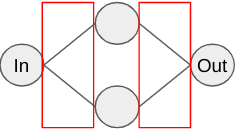

This cell shows how we would use code to create the neural network above.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ExampleNet(nn.Module):  # inherit from PyTorch's neural network base class
    def __init__(self):
        # Initialize parent class (required)
        super().__init__()

        # Define the network architecture:
        # First layer: 1 input -> 2 hidden neurons
        self.fc1 = nn.Linear(1, 2)
        # Second layer: 2 hidden neurons -> 1 output
        self.fc2 = nn.Linear(2, 1)

    def forward(self, net_input):
        # Forward pass - defines how data flows through the network

        # Pass input through first layer
        x = self.fc1(net_input)
        print(f"Hidden layer outputs (raw): {x}")

        # Apply ReLU activation to introduce non-linearity
        # ReLU: if x < 0, output 0; else output x
        x = F.relu(x)
        print(f"Hidden layer outputs (after ReLU): {x}")

        # Pass through final layer to get prediction
        x = self.fc2(x)
        print(f"Network output: {x}")

        return x

# Test the network
net_in = torch.tensor([1.0])  # Create input tensor
net = ExampleNet()  # Initialize network
net_out = net(net_in)  # Run input through network

These numbers and dimensions don’t mean much yet, so let’s build something cool—a network that takes a 3x3 board and outputs a 3x3 move probability grid.

When picking a network size:
  - Look up examples of similar models online.
    - Too small? It won’t learn well. Too big? It’ll overfit and train forever.
    - The rest is trial and error until it works!

In [ ]:
class TicTacToeNet(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, net_input):
        pass

Here's an example network. The key thing is that the number of input and output neurons should both be 9.

In [ ]:
class TicTacToeNet(nn.Module):
    def __init__(self, input_size=9, hidden_size=36, output_size=9):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, net_input):
        x = self.fc1(net_input)
        x = torch.relu(x)

        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)
        net_output = torch.sigmoid(x)
        return net_output

If you tried to feed the board directly to the network, you would've gotten an error—that's because out network only eats and poops out tensors!💩

What's a tensor?

A tensor is like a list that only holds numbers. In neural networks, each tensor also has a `grad` property which tracks how much each weight and bias contributed to the final result to save computing time.

In fact, weights and biases in each layer of a neural network are stored as tensors. To perform calculations, we need to convert the input into a tensor first.

In [ ]:
layer = nn.Linear(4, 2)
print(layer.weight)
print(layer.bias)

Tensors can also come in any dimension. Each additional dimension is represented by another layer of nesting.

```python
# 0D Tensor (scalar)
0
# 1D Tensor (vector)
[0, 0]
# 2D Tensor (matrix)
[[0, 0],
 [0, 0]]
# 3D Tensor
[
  [[0, 0],
   [0, 0]],

  [[0, 0],
   [0, 0]]
]
```

Before using our network, we need to flatten the board since our network structure only accepts 1D tensor inputs. Luckily, PyTorch makes it easy!

Also, don't forget to initialize input tensors with ```dtype=torch.float``` so the operations between the network’s weight, bias, and input tensors work properly.

In [ ]:
board_state = [[1, 0, 0],
               [0,-1, 0],
               [1, 0, 0]]
board_tensor = torch.tensor(board_state, dtype=torch.float)
print(board_tensor)
flattened_board_tensor = board_tensor.flatten()
print(flattened_board_tensor)

Let's feed our board into the network!

In [ ]:
board_state = [[1, 0, 0],
               [0,-1, 0],
               [1, 0, 0]]

flattened_board = torch.tensor(board_state, dtype=torch.float).flatten()
net = TicTacToeNet()
net_out = net(flattened_board)
print(net_out)  # Actual network output is in the form of a 1D tensor
print(net_out.view(3, 3))  # View probabilites as a 3x3 grid

These numbers in the grid are the probabilities the untrained network has assigned to each move. They're totally random right now but it'll get better once the network starts training🏋️🏋️🏋️

Let's teach the network how to use those _weights_ 😁

### Training the network

What do we need to train the network again? The more specific your steps, the better :)

🛑 + 🧠

Here’s what we need:  
1. A **loss function**—this tells us how wrong the network's predictions are compared to the best moves we expect.  
2. **Gradient descent**—this helps the network tweak its settings (weights and biases) to improve its predictions by reducing that loss.   

Let's start with measuring *how wrong* the network is. How might we do that?

🛑 + 🧠

We’ll compare its predicted move probabilities with those from our trusty MCTS (Monte Carlo Tree Search) grid. Bigger differences = bigger loss.  

One simple way is to square the difference for each move. For example:  
- If the network says a move (0, 0) has a 60% chance (0.6) and MCTS says 10% (0.1), the loss for that move is:  
  \((0.6 - 0.1)^2 = 0.25\).  
- We do this for all moves, average the results, and voila—we have our loss function

But why code all that by hand when PyTorch already has a built-in tool? It's called **MSE (Mean Squared Error) Loss**, and here’s how we use it:  
1. Create a loss calculator: `loss_metric = nn.MSELoss()`.  
2. Feed it the network’s predictions and the target values—it’ll give you the loss.  

Here's an example below:


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

loss_metric = nn.MSELoss()
prediction = torch.tensor([0.6, 0.8])
target = torch.tensor([0.1, 0.8])
# Loss for (0.6 - 0.1)^2 = 0.25
# Loss for (0.8 - 0.8)^2 = 0
# Average of the two losses = 0.125
loss = loss_metric(prediction, target)
print(loss)

How do we adjust the network's parameters based on the loss?

🛑 + 🧠

Calculate how small changes in the weights and biases affect the loss (i.e., the derivatives of the loss with respect to the weights and biases). If you want to refresh your knowledge of derivatives, check out 3blue1brown's calculus playlist.

Otherwise, just know there's a mathematical way to see how weights and biases impact the loss. This includes which direction and magnitude we need to nudge each weight and bias by to reduce the loss!

---

How do we code this? PyTorch has us covered :)

Let's go over how we'd implement 1 step of gradient descent with PyTorch:

1. **Calculate the Loss:**  
   Measure how far the network’s prediction is from the target using a loss function.

2. **Compute Gradients:**  
   Call `loss.backward()` to calculate how much and in which direction to adjust each weight and bias to reduce the loss.

3. **Update Weights:**  
   Call `optimizer.step()` to adjust the network's weights and biases based on the gradients. Think of the optimizer object like a coach that tells your neural network how to adjust each weight and bias :)

---



Let's break it down with a simple example!

Imagine a neural network with just one neuron. I've set the weight and bias so you can easily follow the math if you'd like.

In this case, the network is modeled by the equation:
y = Wx + b

```python
# y = network output
# W = weight
# x = input
# b = bias
```

For our example, we want the network to give an output of 2 when the input is 2.

Visually, we're aiming for the equation of the line to pass through the point (2, 2).

In [ ]:
class SingleNeuronNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)  # Define a fully connected layer with 1 input and 1 output
        self.fc1.weight.data = torch.tensor([[0.5]])  # Set weight to 0.5
        self.fc1.bias.data = torch.tensor([0.5])  # Set bias to 0.5

    def forward(self, x):
        y = self.fc1(x)  # Apply the linear transformation (y = Wx + b)
        return y  # Return the output

Next we create the network, loss function, optimizer, and a tensor storing the target output. The optimizer takes the network’s parameters and a learning rate as input.
- A **small learning rate** makes slow, careful updates to the network's weights and biases.  
- A **large learning rate** takes bigger steps but risks overshooting the goal.

In [ ]:
# Creating the network, loss metric, and optimizer objects.
net = SingleNeuronNet()
loss_metric = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
target = torch.tensor([2.0])

We run an initial test on the network.

In [ ]:
prediction = net(torch.tensor([2.0]))
print("Net prediction")
print(prediction)
print()
loss = loss_metric(prediction, target) # loss = (2.0 - 1.5)^2 = 0.25
print("Loss")
print(loss)

Remmeber how all weights and biases are stored in PyTorch tensors with a `grad` property, which tracks how much each weight and bias contributed to the final result?

When `loss.backward()` is called `grad` (short for gradient) is updated with the derivatives of the loss with respect to each weight or bias in the tensor.

In [ ]:
loss.backward()
print("Weight & bias gradients set after loss.backward():")
print()
print("Weight gradient")
print(net.fc1.weight.grad)


print()
print("Bias gradient")
print(net.fc1.bias.grad)
print()

Here's an example to build intuition for what the gradient represents.

Imagine you're hiking on a mountain path (the red curve) and trying to reach the valley (the minimum). Your position on the path is the weight, and the height is the error.

At ```x = -1```, the gradient (represented by the slope of the blue line) is ```-2```, meaning the path slopes downward to the right. To reduce the error, you should move right (increase the weight). If you were at ```x = 0.5``` instead, the slope would be positive, meaning you should move left (decrease the weight).

The gradient is like the network's guide, pointing it to the valley!

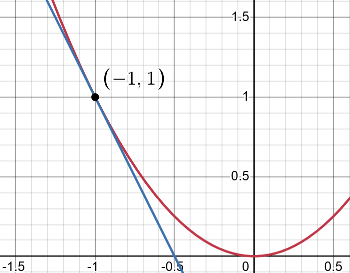)

Finally, we call the step() method of our SGD optimizer, which updates the weights and biases using the gradients from loss.backward(), improving the model's accuracy with each step.

As the network's weights and biases are adjusted, it starts to learns specific patterns in the data.

In [ ]:
optimizer.step()
print("\nWeights & biases adjusted after optimizer.step():")
print("==== Weight ====")
print(net.fc1.weight.data)
print()
print("==== Bias ====")
print(net.fc1.bias.data)
print()

prediction = net(torch.tensor([2.0]))
print("==== Net prediction ====")
print(prediction)
print()
print("==== Loss ====")
loss = loss_metric(prediction, target)
print(loss)

Okay, time for an exercise!

Create a training loop which applies the techniques we've learned to teach our network to model the equation of a line.

Run the code below to generate the training data. Each item in the list represents an (input, output) pair.

In [ ]:
import random


def generate_line_coordinates(slope, y_intercept, num_points):
    """
    Generates a list of coordinates (x, y) that lie on a line. Skipping every other point.

    Args:
        slope: The slope of the line.
        y_intercept: The y-intercept of the line.
        num_points: The number of coordinate points to generate.

    Returns:
        A list of tuples, where each tuple represents a coordinate (x, y).
    """
    training_coordinates = []
    for x in range(0, num_points, 2):
        y = slope * x + y_intercept
        training_coordinates.append((x, y))
    random.shuffle(training_coordinates)
    testing_coordinates = []
    for x in range(1, num_points, 2):
        y = slope * x + y_intercept
        testing_coordinates.append((x, y))
    random.shuffle(testing_coordinates)

    return training_coordinates, testing_coordinates

slope = 2
y_intercept = 1
num_points = 30

training_coordinates, testing_coordinates = generate_line_coordinates(slope, y_intercept, num_points)
print(training_coordinates)

Make sure to run ```optimizer.zero_grad()``` before ```loss.backward()``` to clear the gradients from the previous training loop iteration. Otherwise the gradients from ```loss.backward()``` will accumulate until the newtork start making adjustments that are too big (because of the large accumulated gradient).

In [ ]:
net = SingleNeuronNet()

loss_metric = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001)  # Suggested learning rate

for x, y in training_coordinates:
    pass # Replace this with your implementation
# Suggestion: Try printing predictions after training to see improvement!


Test the network below when you are ready!

In [ ]:
# Test network
total_loss = 0
for x, y in testing_coordinates:
    target_tensor = torch.tensor([y], dtype=torch.float)
    prediction_tensor = net(torch.tensor([x], dtype=torch.float))
    loss = loss_metric(prediction_tensor, target_tensor)
    total_loss += loss.item()
print(f"Average Loss: {total_loss/len(testing_coordinates)}")

# Print network weight and bias
print("==== Weight ====")
print(net.fc1.weight.data)  # We expect this to be close to 2
print()
print("==== Bias ====")
print(net.fc1.bias.data)  # We expect this to be close to 1

Congrats! You just created your first full training loop!

Short summary of my solution:

1. Initialize the model, loss function, and optimizer.  
2. Loop through the data to make predictions and calculate the error.  
3. Clear old gradients.
4. Compute new ones with `loss.backward()`.
5. Update the model using `optimizer.step()`.



In [ ]:
# Solution
net = SingleNeuronNet()

loss_metric = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

for x, y in training_coordinates:
    target_tensor = torch.tensor([y], dtype=torch.float)
    prediction_tensor = net(torch.tensor([x], dtype=torch.float))
    loss = loss_metric(prediction_tensor, target_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Loss: {loss}")

    # Extra info if you are curious
    # print(f"Net input: {x}")
    # print(f"Weight: {net.fc1.weight.data}")
    # print(f"Weight gradient: {net.fc1.weight.grad}")
    # print(f"Bias: {net.fc1.bias.data}")
    # print(f"Bias gradient: {net.fc1.bias.grad}")
    # print(f"Target output: {target_tensor}")
    # print(f"Net output: {prediction_tensor}\n")


### Building the Ultimate Tic-Tac-Toe AI

We have everything we need to create the tic-tac-toe network now!✨

Copy the code above (with all our Board, MCTS, game generation, and Network classes) to your editor first.

Now let's train it! You'll know it's working when the loss starts dropping. We'll get it to play actual games next ;)

If you are _really_ stuck check out the "Training" region of the "Final code" section up top. To get there, click [this](#training) and scroll up.



You got this ^-^

#### Previous classes & functions

In [ ]:
# region Board
"""Board"""
class Board():
    def __init__(self, width, height, win_length, turn, state=None, empties=None):
        self.width = width
        self.height = height
        self.win_length = win_length
        self.turn = turn
        if state == None:
            self.state = tuple([0 for _ in range (width)] for _ in range(height))
            self.empties = [(x, y) for y in range (height) for x in range(width)]
        else:  # Ensures a deepcopy is created
            self.state = tuple(map(list, state))
            self.empties = [*empties]

    def __str__(self):
        symbols = {1: "X", -1: "O", 0: "_"}
        return "\n".join(str([symbols[token] for token in row]) for row in self.state)

    def deepcopy(self):
        return Board(self.width, self.height, self.win_length, self.turn, self.state, self.empties)

    def out_of_bounds(self, square):
        x, y = square
        return (x < 0 or             # Left edge
                y < 0 or             # Top edge
                x >= self.width or   # Right edge
                y >= self.height)    # Bottom edge

    def outcome(self, last_move):
        player = self.state[last_move[1]][last_move[0]]
        directions = [(-1, -1), (-1, 0), (-1, 1),
                      ( 0, -1),          ( 0, 1),
                      ( 1, -1), ( 1, 0), ( 1, 1)]
        for dx, dy in directions:
            line_length = 1
            # Check in one direction
            x, y = last_move[0] + dx, last_move[1] + dy
            while not self.out_of_bounds((x, y)) and self.state[y][x] == player:
                line_length += 1
                x += dx
                y += dy
            # Check in the opposite direction
            x, y = last_move[0] - dx, last_move[1] - dy
            while not self.out_of_bounds((x, y)) and self.state[y][x] == player:
                line_length += 1
                x -= dx
                y -= dy
            if line_length >= self.win_length:
                return player
        if len(self.empties) == 0:
            return 0
        return None

    def make_move(self, move_coords: tuple):
        try:
            self.empties.remove(move_coords)
            self.state[move_coords[1]][move_coords[0]] = self.turn
            self.turn *= -1
        except:
            raise ValueError("Illegal move")
# endregion

# region MCTS
"""MCTS"""
class MCTS:
    class Node:
        def __init__(self, parent, board, move):
            self.parent = parent
            self.children = []
            self.visit_count = 0
            self.total_value = 0
            self.board = board
            self.move = move

        def is_terminal(self):
            return self.board.outcome(self.move) != None

        def is_leaf(self):
            return self.children == []

    def __init__(self, board):
        self.root_node = self.Node(None, board, (-2,-2))
        self.c = 1.4142

    def uct(self, parent, node, player_num):
        if node.visit_count == 0:
            return float("inf")
        else:
            return (player_num * node.total_value/node.visit_count) + self.c * math.sqrt(math.log(parent.visit_count) / node.visit_count)

    def select(self, node):
        if node.is_leaf():
            return node
        else:
            chosen_node = max(node.children, key=lambda child: self.uct(node, child, node.board.turn))
            return self.select(chosen_node)

    def expand(self, node):
        legal_moves = node.board.empties
        for m in legal_moves:
            child_board = node.board.deepcopy()
            child_board.make_move(m)
            child_node = self.Node(node, child_board, m)
            node.children.append(child_node)

    def evaluate(self, node, playouts):
        outcome = node.board.outcome(node.move)
        if outcome != None:
            return outcome
        else:
            total_value = 0
            for _ in range (playouts):
                total_value += self.play_random_game(node.board.deepcopy())
            return total_value / playouts

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def backpropagate(self, node, evaluation):
        node.visit_count += 1
        node.total_value += evaluation
        if node.parent != None:
            self.backpropagate(node.parent, evaluation)

    def search(self, iterations, playouts=20):
        for _ in range(iterations):
            node = self.select(self.root_node)
            if node.visit_count == 0 or node.is_terminal():
                node_eval = self.evaluate(node, playouts)
                self.backpropagate(node, node_eval)
            else:
                self.expand(node)
                child_node = random.choice(node.children)
                child_node_eval = self.evaluate(child_node, playouts)
                self.backpropagate(child_node, child_node_eval)
        move_probs = [[0 for _ in range(self.root_node.board.width)] for _ in range(self.root_node.board.height)]
        for child_node in self.root_node.children:
            prob = child_node.visit_count / self.root_node.visit_count
            move_probs[child_node.move[1]][child_node.move[0]] = prob
        return move_probs


def choose_move(move_probs, temperature=1):
    """
    Selects a move based on the Monte Carlo Tree Search (MCTS) probabilities, adjusting for temperature to control exploration versus exploitation.
    Parameters:
        temperature (float): Controls the randomness of the move selection.
            Higher temperatures (>1) make the move selection more random (exploration),
            while lower temperatures (<1) make it more greedy (exploitation).
            Default is 1.
    Returns:
        tuple: The selected move as a tuple of (x, y) coordinates.
    """
    # Get all moves and their probabilities from the MCTS output
    moves = []
    probs = []
    for y in range(len(move_probs)):
        for x in range(len(move_probs[y])):
            if move_probs[y][x] > 0:
                moves.append((x, y))
                # Apply temperature to sharpen/flatten distribution
                prob = math.pow(move_probs[y][x], 1 / temperature)
                probs.append(prob)
    # Normalize probabilities
    prob_sum = sum(probs)
    probs = [p / prob_sum for p in probs]
    # Choose move based on probability distribution
    return random.choices(moves, weights=probs)[0]
# endregion

# region Game generation
"""Game generation"""
def generate_games(num_games, mcts_iterations, board_params=(3, 3, 3)):
    training_examples = []
    for game_num in tqdm.tqdm(range(num_games)):
        game_board = Board(*board_params, 1)
        while True:
            mcts_engine = MCTS(game_board)
            move_probs = mcts_engine.search(mcts_iterations)
            training_examples.append(([row[:] for row in game_board.state], move_probs))

            selected_move = choose_move(move_probs)
            game_board.make_move(selected_move)
            if game_board.outcome(selected_move) != None:
                break
    return training_examples
# endregion

# region Network
"""Network"""
class TTTNet(nn.Module):
    def __init__(self, input_size=9, hidden_size=36, output_size=9):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)

        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
# endregion

#### Network training template

In [ ]:
# Generate data for model training

net = TicTacToeNet()
# Training settings
# Hint: Try the SGD optimizer with a learning rate of 0.3!
epochs = 25
for epoch in range(epochs):
    pass # Go through all the training examples
         # and update our network with each one!

torch.save(net.state_dict(), 'tictactoe_net.pth')  # Save the model to a file

Congratulations on building your own ULTIMATE Tic Tac Toe network :DDDD 🎊




### Evaluating the network!

Did you notice how the loss stops dropping after a while?

How do we determine the level our network reached when the loss stopped dropping? Be specific.

🛑 + 🧠

Two Ideas:
1. Play games against known opponents (e.g., MCTS, random moves).
2. Check how often it matches MCTS’s top moves from training data.


Let’s start with playing games. Wanna code it yourself? Go for it! Or check out my version:

How it works:
1. Players are objects with a `move` method (input: board, output: move).
2. The `play_game` function runs a game by calling each player’s `move` method until the game ends.
3. The `run_match_series` function simulates multiple games and tracks wins for each player.

Example after this code cell!

In [ ]:
class HumanPlayer():
    def move(self, board, **kwargs):
        while True:
            try:
                move = tuple(map(int, input("Enter move as x,y: ").split(',')))
                return move
            except:
                print("Invalid move, try again")


class NetPlayer():
    def __init__(self, net, deterministic=False):
        self.net = net
        self.deterministic = deterministic

    def move(self, board, print_probs=False):
        board_tensor = torch.tensor(board.state, dtype=torch.float).flatten()
        board_tensor = board_tensor * board.turn
        move_probs = self.net(board_tensor)

        if print_probs:
            print("\nNetwork probabilities:")
            for y in range(board.height):
                print([f"{move_probs[y*board.width + x]:.3f}" for x in range(board.width)])

        for move in range(board.width * board.height):
            if (move % board.width, move // board.height) not in board.empties:
                move_probs[move] = 0.0

        if self.deterministic:
            best_move_idx = torch.argmax(move_probs).item()
        else:
            best_move_idx = torch.multinomial(move_probs, 1).item()
        best_move = (best_move_idx % board.width, best_move_idx // board.height)

        return best_move


class RandomPlayer():
    def move(self, board, **kwargs):
        return random.choice(board.empties)


class MCTSPlayer():
    def __init__(self, iterations, deterministic=False):
        self.deterministic = deterministic
        self.iterations = iterations

    def move(self, board, print_probs=False):
        mcts = MCTS(board)
        move_probs = mcts.search(self.iterations)
        move_probs = torch.tensor(move_probs).flatten()

        if print_probs:
            print("\nMCTS probabilities:")
            for row in move_probs:
                print([f"{prob:.3f}" for prob in row])

        if self.deterministic:
            best_move_idx = torch.argmax(move_probs).item()
        else:
            best_move_idx = torch.multinomial(move_probs, 1).item()
        best_move = (best_move_idx % board.width, best_move_idx // board.height)

        return best_move


def play_game(board, player_a, player_b, print_game=False):
    outcome = None
    illegal_move_count = 0
    while outcome == None:
        if print_game:
            player = 'X' if board.turn==1 else 'O'
            print(f"\n{'='*7} {player} player's turn {'='*7}")
            print(f"\nBoard:\n{board}")
        player = player_a if board.turn == 1 else player_b
        move = player.move(board, print_probs=print_game)
        try:
            board.make_move(move)
        except:
            if illegal_move_count < 3:
                print("Illegal move, try again")
                illegal_move_count += 1
                continue
            else:
                print("Too many illegal moves, aborting game")
                return None
        outcome = board.outcome(move)
    if print_game:
        print(f"\nGame over!")
        print(f"\nFinal board:\n{board}")
    return outcome


def run_match_series(player_a, player_b, num_games, board_params=(3, 3, 3)):
    """
    Run a series of games between two players, where each player gets an equal
    opportunity to play first. The function keeps track of wins for each player across all games.
    """
    # Initialize win counters for both players
    player_a_wins = 0
    player_b_wins = 0
    player_list = [[player_a, player_a_wins],
                   [player_b, player_b_wins]]

    # Play specified number of games, alternating who goes first
    for game in tqdm.tqdm(range(num_games)):
        current_first = player_list[0][0]
        current_second = player_list[1][0]
        outcome = play_game(Board(*board_params, 1), current_first, current_second, print_game=False)

        # Update win counts based on game outcome
        if outcome == 1:
            player_list[0][1] += 1    # First player won
        elif outcome == -1:
            player_list[1][1] += 1    # Second player won

        player_list.reverse()

    # Return in original order: player_a first, player_b second
    return player_list if player_list[0][0] == player_a else player_list.reverse()

Let's pit our net against an MCTS bot (200 iterations) and a random player!

Setting ```deterministic = False``` lets the MCTS and the net pick moves based on their move probability outputs, keeping the games varied. Setting it to ```True``` means they always pick the top move, resulting in better performance. However, this results in repeating the same game when _both_ players have ```deterministic = True```

In [ ]:
# net = TicTacToeNet()  # Create a new net
# net.load_state_dict(torch.load('tictactoe_net.pth'))  # Load the saved model into this net

net_player = NetPlayer(net, deterministic=False)
random_player = RandomPlayer()
mcts_player = MCTSPlayer(200, deterministic=False)

net_vs_random = run_match_series(net_player, random_player, 1000)
print(f"\nNet vs. Random: {net_vs_random}")

net_vs_mcts = run_match_series(net_player, mcts_player, 1000)
print(f"\nNet vs. MCTS: {net_vs_mcts}")

The only catch? Running this during every single epoch could take ages, especially on a larger board.

A faster method (which provides a rougher evaluation), is comparing the network's predictions to the MCTS top moves. Instead of calculating loss, we opt for a more practical metric—accuracy

Here’s how I approached it:
A prediction counts as correct if the network’s highest-probability move shows up in the MCTS algorithm’s list of top moves.

This ensures that if the MCTS algorithm ranks multiple moves as equally strong (e.g., all moves with a probability within 0.1 of the top MCTS move), the network's prediction is considered correct as long as it selects any of those top-ranked moves.

We get the network's accuracy by dividing the correct number of predictions by the total number of predictions.



In [ ]:
def calculate_accuracy(
    data_set,
    net,
    board_size=(3, 3),
    probability_threshold=0.1
):
    """
    A prediction is considered correct if the network's highest probability move
    is within the probability_threshold of the target's highest probability move.
    """
    correct = 0
    for board, move_probs in data_set:
        output = net(board)
        best_move = torch.argmax(move_probs)
        best_moves = (move_probs >= move_probs[best_move] - probability_threshold).nonzero().flatten()
        if torch.argmax(output) in best_moves:
            correct += 1
    return correct / len(data_set)


Here's an example on how to use it.

You could also run it at the end of every training epoch in your training loop.

In [ ]:
test_data = generate_games(10, 200)
test_data = process_game_data(test_data)  # convert board and move_probs to tensors and flatten
accuracy = calculate_accuracy(test_data, net)
print(f"Accuracy: {accuracy}")

## Wrapping up

That's it!! Congrats on getting this far🎉🎊🎉🎊🎉

You've built your own Tic-Tac-Toe AI and explored key concepts like getting appropiate training data, choosing network architecture, and evaluating models—essential skills for *any* machine learning project.


### Generalizing to Other Board Sizes

At the beginning of this tutorial, I mentioned that this approach generalizes to various board sizes.

However, generating games for such larger boards can take significantly longer—potentially an hour or more! This happens because:
1. **MCTS random playouts** take longer to finish as the board size grows.
2. We need more **iterations of MCTS** to identify the **top moves** and generate high-quality training data.

The challenges don't stop there. Even after generating data, we’ll likely need a **larger network** and **longer training times** to capture the additional complexity.

But don’t worry! There are a couple of ways to overcome these barriers:

1. Replace random MCTS playouts with **faster neural network evaluations**.  
2. Use a **convolutional neural network (CNN)**, which enables the network to easily recognize and apply patterns across different parts of the board.

We’ll cover these in *Part 2*, so stay tuned!  


### Next steps

Remember, this approach isn’t just for Tic-Tac-Toe—it can inspire AI projects for anything that excites you, game-related or not! :)

Finally, your **feedback is invaluable**, so let me know how this tutorial helped and how it could be improved [here](https://docs.google.com/forms/d/e/1FAIpQLSf1Hyd4vS6Sx6YDmOOyynrfBkKfRfckkWABxIGfP5Joj1Ik2A/viewform). Keep building =D🛠️